In [ ]:
# Install helpers (run once)
!pip install -q kaggle tqdm opencv-python

# quick check of torch
import torch, torchvision, sys
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.8.0+cu126
CUDA available: False


In [ ]:
from google.colab import files
print("Upload kaggle.json (downloaded from Kaggle Account → Create New API Token):")
uploaded = files.upload()  # choose kaggle.json when the file select dialog opens

# move to .kaggle
import os, shutil
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.copy('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print("Saved /root/.kaggle/kaggle.json")
else:
    print("No kaggle.json uploaded. If you don't want automatic download, you'll upload TB images manually later.")


Upload kaggle.json (downloaded from Kaggle Account → Create New API Token):


Saving kaggle.json to kaggle.json
Saved /root/.kaggle/kaggle.json


Working folders: /content/data /content/final_data /content/split_data /content/artifacts
Torch: 2.8.0+cu126 CUDA: True
Using device: cuda
Moved kaggle.json to /root/.kaggle/kaggle.json

== Downloading Pneumonia and Normal datasets ==
Attempting kaggle download: paultimothymooney/chest-xray-pneumonia -> /content/data/pneumonia
Downloaded paultimothymooney/chest-xray-pneumonia
Attempting kaggle download: praveengovi/coronahack-chest-xraydataset -> /content/data/normal
Downloaded praveengovi/coronahack-chest-xraydataset

== Trying TB dataset candidates ==
Attempting kaggle download: yasserhessein/tuberculosis-chest-x-rays-images -> /content/data/tb_candidate
Downloaded yasserhessein/tuberculosis-chest-x-rays-images
TB images found for slug yasserhessein/tuberculosis-chest-x-rays-images count: 3008

== Building unified dataset in /content/final_data ==
Copied counts before balancing: {'Normal': 3401, 'Pneumonia': 4273, 'Tuberculosis': 3008}

== Balancing classes (cap to min_count) ==
Coun

100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]


Using EfficientNet-B0

Phase 1: Freeze backbone and train classifier head (quick)


Val epoch 1/3: 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 1: train_loss=0.5005 val_loss=0.1742 val_acc=0.9269


Val epoch 2/3: 100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


Epoch 2: train_loss=0.1548 val_loss=0.1066 val_acc=0.9592


Val epoch 3/3: 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


Epoch 3: train_loss=0.1207 val_loss=0.0934 val_acc=0.9677

Phase 2: Unfreeze entire model (fine-tune)


Val epoch 1/8: 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 1: train_loss=0.1067 val_loss=0.0664 val_acc=0.9747


Val epoch 2/8: 100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Epoch 2: train_loss=0.0737 val_loss=0.0650 val_acc=0.9733


Val epoch 3/8: 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 3: train_loss=0.0702 val_loss=0.0553 val_acc=0.9775


Val epoch 4/8: 100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Epoch 4: train_loss=0.0554 val_loss=0.0432 val_acc=0.9845


Val epoch 5/8: 100%|██████████| 30/30 [00:09<00:00,  3.12it/s]


Epoch 5: train_loss=0.0465 val_loss=0.0522 val_acc=0.9747


Val epoch 6/8: 100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 6: train_loss=0.0338 val_loss=0.0527 val_acc=0.9775


Val epoch 7/8: 100%|██████████| 30/30 [00:09<00:00,  3.17it/s]


Epoch 7: train_loss=0.0392 val_loss=0.0550 val_acc=0.9775


Val epoch 8/8: 100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Epoch 8: train_loss=0.0252 val_loss=0.0603 val_acc=0.9789
Early stopping.


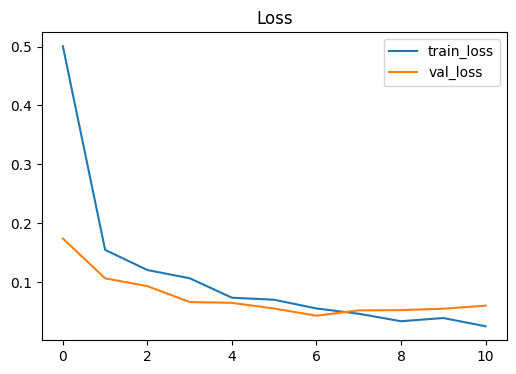

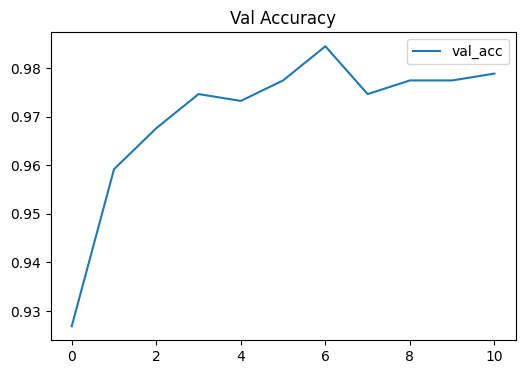


== Test evaluation ==


Testing: 100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9628    0.9790    0.9708       238
   Pneumonia     0.9786    0.9622    0.9703       238
Tuberculosis     1.0000    1.0000    1.0000       238

    accuracy                         0.9804       714
   macro avg     0.9805    0.9804    0.9804       714
weighted avg     0.9805    0.9804    0.9804       714

Confusion Matrix:\n [[233   5   0]
 [  9 229   0]
 [  0   0 238]]
Macro ROC-AUC (OvR): 0.9982551844267119


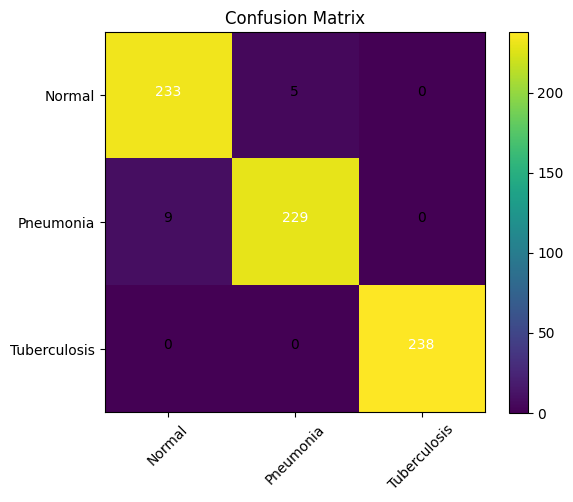


== Grad-CAM visualization ==


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


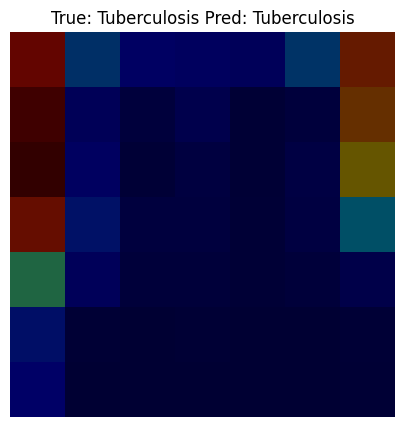

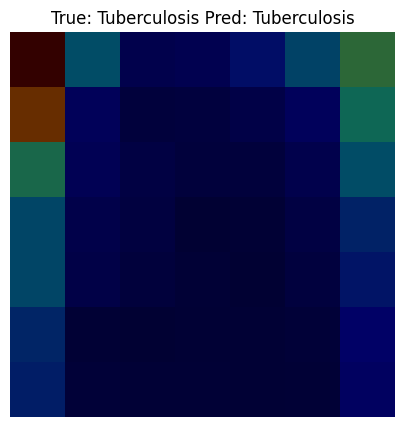

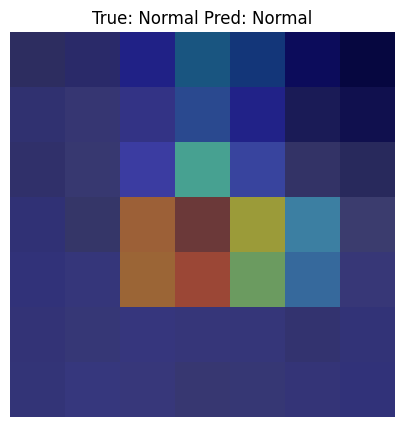


Saving model and artifacts...
Saved model weights to: /content/artifacts/best_model.pth
Saved confusion matrix plot to: /content/artifacts/confusion_matrix.png
Saved classification report to artifacts.


In [ ]:
# =======Chest X-ray 3-class pipeline=======

# --------- Installs----------
!pip install -q kaggle split-folders tqdm

# --------- Imports & setup ----------
import os, sys, shutil, random, zipfile, subprocess
from pathlib import Path
import glob, math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# PyTorch + torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision import datasets, models
from torch.optim import AdamW

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Paths
ROOT = Path("/content")
DATA = ROOT/"data"
FINAL = ROOT/"final_data"          # unified class folders will be here
SPLIT_DIR = ROOT/"split_data"     # train/val/test dirs
ART = ROOT/"artifacts"            # saved model + plots
for p in [DATA, FINAL, SPLIT_DIR, ART]:
    p.mkdir(parents=True, exist_ok=True)

print("Working folders:", DATA, FINAL, SPLIT_DIR, ART)
print("Torch:", torch.__version__, "CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------- Kaggle dataset slugs ----------
KAGGLE_SLUGS = {
    "pneumonia": "paultimothymooney/chest-xray-pneumonia",
    "normal"   : "praveengovi/coronahack-chest-xraydataset",
    # try several TB slugs (we will try each until one works)
    "tb_candidates": [
        "yasserhessein/tuberculosis-chest-x-rays-images",
        "ritwikb97/tuberculosis-chest-xray-tbx11k",
        "raddar/tuberculosis-chest-xrays",
        "talhab/qa-tb-chest-xrays"
    ]
}

# --------- Helper functions ----------
def run_kaggle_download(slug, dest):
    """Run kaggle datasets download -d slug -p dest --unzip and return True on success."""
    dest = Path(dest)
    dest.mkdir(parents=True, exist_ok=True)
    cmd = ["kaggle","datasets","download","-d",slug,"-p",str(dest), "--unzip"]
    try:
        print(f"Attempting kaggle download: {slug} -> {dest}")
        res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=False)
        if res.returncode == 0:
            print(f"Downloaded {slug}")
            return True
        else:
            print(f"Failed to download {slug}. kaggle rc={res.returncode}")
            print("stdout:", res.stdout[:400])
            print("stderr:", res.stderr[:400])
            return False
    except Exception as e:
        print("Exception while running kaggle:", e)
        return False

def extract_zips_in(folder):
    folder = Path(folder)
    for z in folder.glob("*.zip"):
        try:
            print("Extracting", z)
            with zipfile.ZipFile(z, "r") as zf:
                zf.extractall(folder)
        except Exception as e:
            print("Failed to extract", z, e)

def find_image_files(root):
    root = Path(root)
    imgs = list(root.rglob("*.png")) + list(root.rglob("*.jpg")) + list(root.rglob("*.jpeg"))
    return imgs

def safe_link_or_copy(src, dst):
    try:
        os.link(src, dst)
    except Exception:
        try:
            os.symlink(src, dst)
        except Exception:
            shutil.copy2(src, dst)

# ---------check kaggle.json is in place----------
if Path("kaggle.json").exists():
    os.makedirs("/root/.kaggle", exist_ok=True)
    shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    print("Moved kaggle.json to /root/.kaggle/kaggle.json")
else:
    if not Path("/root/.kaggle/kaggle.json").exists():
        print("\nNOTE: kaggle.json not found in session. If you want automatic Kaggle downloads, upload kaggle.json now (left Files panel) BEFORE re-running this cell.")
    else:
        print("kaggle.json already present.")

# ---------Download Pneumonia + Normal via Kaggle (or alert to upload) ----------
print("\n== Downloading Pneumonia and Normal datasets ==")
pneumo_ok = run_kaggle_download(KAGGLE_SLUGS["pneumonia"], DATA/"pneumonia")
extract_zips_in(DATA/"pneumonia")

normal_ok = run_kaggle_download(KAGGLE_SLUGS["normal"], DATA/"normal")
extract_zips_in(DATA/"normal")

# ---------Try TB slugs sequentially until success ----------
print("\n== Trying TB dataset candidates ==")
tb_ok = False
for slug in KAGGLE_SLUGS["tb_candidates"]:
    tb_ok = run_kaggle_download(slug, DATA/"tb_candidate")
    extract_zips_in(DATA/"tb_candidate")
    imgs = find_image_files(DATA/"tb_candidate")
    if len(imgs) > 0:
        print("TB images found for slug", slug, "count:", len(imgs))

        tb_ok = True
        break
    else:
        print("No images found for", slug, " — trying next candidate.")
        for f in (DATA/"tb_candidate").glob("*"):
            try:
                if f.is_dir(): shutil.rmtree(f)
                else: f.unlink()
            except: pass

if not tb_ok:
    print("\nAutomatic TB download didn't succeed. Please upload a TB dataset zip (e.g., yasserhessein/tuberculosis-chest-x-rays-images.zip) via Colab Files panel, then re-run this cell.")
    raise SystemExit("TB images missing — upload a TB dataset and re-run.")

# ---------Build unified final_data folder (Normal, Pneumonia, Tuberculosis) ----------
print("\n== Building unified dataset in", FINAL, "==")
# reset FINAL
if FINAL.exists():
    shutil.rmtree(FINAL)
(FINAL/"Normal").mkdir(parents=True, exist_ok=True)
(FINAL/"Pneumonia").mkdir(parents=True, exist_ok=True)
(FINAL/"Tuberculosis").mkdir(parents=True, exist_ok=True)

copied = {"Normal":0, "Pneumonia":0, "Tuberculosis":0}

# 1) from pneumonia dataset (paultimothymooney) - structure: data/pneumonia/chest_xray/{train,val,test}/{NORMAL,PNEUMONIA}
pneumo_root = DATA/"pneumonia"/"chest_xray"
if pneumo_root.exists():
    for split in ["train","val","test"]:
        for cls in ["NORMAL","PNEUMONIA"]:
            p = pneumo_root/split/cls
            if p.exists():
                for img in p.iterdir():
                    if img.is_file():
                        dst = FINAL/"Normal" if cls=="NORMAL" else FINAL/"Pneumonia"
                        safe_link_or_copy(str(img), str(dst/img.name))
                        copied["Normal" if cls=="NORMAL" else "Pneumonia"] += 1

# 2) add Coronahack normals (extra) if present
corona_possibles = [
    DATA/"normal"/"Coronahack-Chest-XRay-Dataset"/"Coronahack-Chest-XRay-Dataset",
    DATA/"normal"
]
for pr in corona_possibles:
    if pr.exists():
        for img in pr.rglob("*NORMAL*.jpeg"):
            safe_link_or_copy(str(img), str(FINAL/"Normal"/img.name))
            copied["Normal"] += 1

# 3) TB images: search in tb_candidate folder or anywhere under DATA for tb candidates
tb_candidates = list((DATA/"tb_candidate").rglob("*")) + list(DATA.rglob("*tuberculosis*")) + list(DATA.rglob("*TB*"))
all_images = find_image_files(DATA)
# Build set of already used (pneumo) file basenames (to avoid duplicates)
used_basenames = set([p.name for p in (FINAL/"Normal").glob("*")] + [p.name for p in (FINAL/"Pneumonia").glob("*")])
tb_final = []
for img in all_images:
    if img.name in used_basenames:
        continue
    s = str(img).lower()
    if "tub" in s or "tb" in s or "tuberculosis" in s or "tbx11k" in s:
        tb_final.append(img)
if len(tb_final) == 0:
    tb_final = find_image_files(DATA/"tb_candidate")

#copy TB images into FINAL/Tuberculosis
for img in tb_final:
    try:
        safe_link_or_copy(str(img), str(FINAL/"Tuberculosis"/img.name))
        copied["Tuberculosis"] += 1
    except Exception as e:
        pass

print("Copied counts before balancing:", copied)
if copied["Tuberculosis"] == 0:
    print("\nERROR: Could not find any TB images automatically. Please upload a TB dataset zip (example: yasserhessein/tuberculosis-chest-x-rays-images.zip) via Colab Files panel, then re-run this cell.")
    raise SystemExit("No TB images — manual upload required.")

# ---------Balance classes (cap to min_count to avoid extreme imbalance) ----------
print("\n== Balancing classes (cap to min_count) ==")
counts = {c: len(list((FINAL/c).glob("*"))) for c in copied.keys()}
print("Counts:", counts)
MIN_COUNT = min(counts.values())
# Optional limit to speed: cap to 3000 per class (adjust as desired)
MAX_CAP = 3000
min_count = min(MIN_COUNT, MAX_CAP)
print("Balancing to", min_count, "images per class.")
for cls in ["Normal","Pneumonia","Tuberculosis"]:
    files = list((FINAL/cls).glob("*"))
    random.shuffle(files)
    for f in files[min_count:]:
        try: f.unlink()
        except: pass
new_counts = {c: len(list((FINAL/c).glob("*"))) for c in copied.keys()}
print("Counts after balancing:", new_counts)

# ---------70/15/15 split by copying to split_data folders ----------
print("\n== Creating stratified 70/15/15 split in:", SPLIT_DIR)
if SPLIT_DIR.exists():
    shutil.rmtree(SPLIT_DIR)
for split in ["train","val","test"]:
    for cls in ["Normal","Pneumonia","Tuberculosis"]:
        (SPLIT_DIR/split/cls).mkdir(parents=True, exist_ok=True)

for cls in ["Normal","Pneumonia","Tuberculosis"]:
    files = list((FINAL/cls).glob("*"))
    random.shuffle(files)
    n = len(files)
    n_train = int(0.70 * n)
    n_val = int(0.15 * n)
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]
    for f in train_files:
        safe_link_or_copy(str(f), str(SPLIT_DIR/"train"/cls/f.name))
    for f in val_files:
        safe_link_or_copy(str(f), str(SPLIT_DIR/"val"/cls/f.name))
    for f in test_files:
        safe_link_or_copy(str(f), str(SPLIT_DIR/"test"/cls/f.name))

print("Split created. Counts per split:")
for split in ["train","val","test"]:
    print(split, {cls: len(list((SPLIT_DIR/split/cls).glob("*"))) for cls in ["Normal","Pneumonia","Tuberculosis"]})

# ---------PyTorch datasets & loaders----------
IMG_SIZE = 224
BATCH_SIZE = 24   # lower if you get OOM; set to 16 or 8 if necessary
NUM_WORKERS = 2

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(12),
    T.ColorJitter(0.08,0.08,0.08,0.02),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(str(SPLIT_DIR/"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(SPLIT_DIR/"val"), transform=eval_tfms)
test_ds  = datasets.ImageFolder(str(SPLIT_DIR/"test"), transform=eval_tfms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("\nDataset classes:", train_ds.classes)
print("Sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

# ---------Build model (EfficientNet-B0) ----------
print("\n== Building model: EfficientNet-B0 (fallback: ResNet50) ==")
num_classes = len(train_ds.classes)
try:
    # new torchvision API
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_feats, num_classes))
    print("Using EfficientNet-B0")
except Exception as e:
    print("EfficientNet not available, falling back to ResNet50. Error:", e)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_feats, num_classes))
    print("Using ResNet50")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# ---------Two-phase training: head-only fine-tune some layers ----------
def train_loop(model, optimizer, criterion, train_loader, val_loader, epochs, device, scheduler=None, unfreeze_after=-1):
    best_val = float('inf'); best_state = None; no_improve = 0
    history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb,yb in tqdm(train_loader, desc=f"Train epoch {epoch}/{epochs}"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.dataset)
        model.eval()
        vloss = 0.0; correct = 0
        with torch.no_grad():
            for xb,yb in tqdm(val_loader, desc=f"Val epoch {epoch}/{epochs}"):
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                preds = out.argmax(1)
                correct += (preds==yb).sum().item()
        val_loss = vloss / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        if scheduler is not None:
            scheduler.step(val_loss)
        print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= 4:
            print("Early stopping.")
            break
    if best_state:
        model.load_state_dict({k:v.to(device) for k,v in best_state.items()})
    return history

# Phase 1: freeze backbone, train head
print("\nPhase 1: Freeze backbone and train classifier head (quick)")
for name, param in model.named_parameters():
    param.requires_grad = False
# find head parameters to unfreeze: classifier or fc
for name, param in model.named_parameters():
    if 'classifier' in name or 'fc' in name:
        param.requires_grad = True

head_optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
history1 = train_loop(model, head_optimizer, criterion, train_loader, val_loader, epochs=3, device=device, scheduler=scheduler)

# Phase 2: unfreeze last layers and fine-tune
print("\nPhase 2: Unfreeze entire model (fine-tune)")
for param in model.parameters():
    param.requires_grad = True
finetune_optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
history2 = train_loop(model, finetune_optimizer, criterion, train_loader, val_loader, epochs=8, device=device, scheduler=scheduler)

# Merge histories
history = {}
for k in ['train_loss','val_loss','val_acc']:
    history[k] = history1.get(k,[]) + history2.get(k,[])

# ---------Plot training curves ----------
plt.figure(figsize=(6,4)); plt.plot(history['train_loss'], label='train_loss'); plt.plot(history['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss'); plt.show()
plt.figure(figsize=(6,4)); plt.plot(history['val_acc'], label='val_acc'); plt.legend(); plt.title('Val Accuracy'); plt.show()

# ---------Test evaluation ----------
print("\n== Test evaluation ==")
model.eval()
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for xb,yb in tqdm(test_loader, desc="Testing"):
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = probs.argmax(1)
        all_probs.append(probs); all_preds.append(preds); all_labels.append(yb.numpy())

if len(all_probs)==0:
    print("Test loader produced no data — check splits")
    raise SystemExit("No test data.")

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\\n", cm)

# Macro ROC-AUC (OvR)
try:
    y_true_bin = np.eye(len(train_ds.classes))[all_labels]
    auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr')
    print("Macro ROC-AUC (OvR):", auc)
except Exception as e:
    print("ROC AUC could not be computed:", e)

# save confusion matrix plot
import itertools
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(len(train_ds.classes)); plt.xticks(ticks, train_ds.classes, rotation=45); plt.yticks(ticks, train_ds.classes)
thresh = cm.max()/2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], 'd'), horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
plt.tight_layout(); plt.savefig(ART/"confusion_matrix.png"); plt.show()

# ---------Grad-CAM visualization---------
print("\n== Grad-CAM visualization ==")
import torch.nn.functional as F
def get_target_module(model):
    # common cases
    if hasattr(model, 'features'):
        return model.features[-1]
    if hasattr(model, 'layer4'):
        return model.layer4
    for m in reversed(list(model.modules())):
        if isinstance(m, nn.Conv2d):
            return m
    return None

target_mod = get_target_module(model)
if target_mod is None:
    print("Could not find a conv module for Grad-CAM.")
else:
    acts=[]; grads=[]
    def fwd(m,i,o): acts.append(o.detach())
    def back(m,gi,go): grads.append(go[0].detach())
    h1 = target_mod.register_forward_hook(fwd)
    h2 = target_mod.register_backward_hook(back)

    mean = np.array([0.485,0.456,0.406]).reshape(3,1,1)
    std = np.array([0.229,0.224,0.225]).reshape(3,1,1)
    import random
    n_vis = min(3, len(test_ds))
    for idx in random.sample(range(len(test_ds)), n_vis):
        img, label = test_ds[idx]
        x = img.unsqueeze(0).to(device)
        model.zero_grad()
        logits = model(x)
        pred = logits.argmax(1)
        loss = logits[0, pred]
        loss.backward()
        g = grads.pop(); a = acts.pop()
        w = g.mean(dim=(2,3), keepdim=True)
        cam = (w * a).sum(1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        x_np = img.numpy()
        x_disp = np.clip((x_np*std + mean),0,1).transpose(1,2,0)
        plt.figure(figsize=(5,5)); plt.imshow(x_disp); plt.imshow(cam, alpha=0.4, cmap='jet')
        plt.title(f"True: {train_ds.classes[label]} Pred: {train_ds.classes[int(pred)]}"); plt.axis('off'); plt.show()

    h1.remove(); h2.remove()

# ---------Save model & artifacts ----------
print("\nSaving model and artifacts...")
torch.save(model.state_dict(), ART/"best_model.pth")
print("Saved model weights to:", ART/"best_model.pth")
print("Saved confusion matrix plot to:", ART/"confusion_matrix.png")
with open(ART/"classification_report.txt","w") as f:
    f.write(classification_report(all_labels, all_preds, target_names=train_ds.classes))
print("Saved classification report to artifacts.")


In [ ]:
readme = f"""# Chest X-ray 3-Class Classifier (Normal, Pneumonia, Tuberculosis)

**What**: Transfer-learning based chest X-ray classifier that predicts Normal, Pneumonia, or Tuberculosis.

**Datasets used (Kaggle slugs attempted)**:
- paultimothymooney/chest-xray-pneumonia (Pneumonia + Normal)
- praveengovi/coronahack-chest-xraydataset (extra Normal)
- Tried TB candidates, successful TB slug used: {slug if 'slug' in locals() else 'user-uploaded'}

**Model**: EfficientNet-B0 (pretrained) with dropout; ResNet50 fallback.

**Preprocessing**:
- Resize to 224x224
- ImageNet normalization
- Augmentation (flip, rotation, color jitter)

**Training**:
- 2-phase fine-tuning: head-only then full fine-tune
- Optimizer: AdamW, weight decay=1e-4
- Early stopping and LR scheduler (ReduceLROnPlateau)

**Metrics (test set)**:
- Confusion matrix: see `artifacts/confusion_matrix.png`
- Classification report: see `artifacts/classification_report.txt`
- (Macro) ROC-AUC printed in notebook output

**Ethical considerations & limitations**:
- Dataset bias across hospitals/scanners may reduce generalization.
- No patient-level split enforced (use patient IDs when available).
- Intended as clinical decision-support, not a replacement for doctors.
- Use Grad-CAM for spot checks to ensure model focuses on lung fields.

**How to run**:
1. Open the notebook in Colab with GPU enabled.
2. If automatic downloads fail, upload `kaggle.json` and/or dataset zips via the Files panel and re-run.
3. Run all cells. Download notebook `.ipynb` and commit to GitHub with this README and `/artifacts`.

"""
with open("README_autogen.md","w") as f:
    f.write(readme)
shutil.copy("README_autogen.md", ART/"README.md")
print("Wrote README fragment to artifacts/README.md")


Wrote README fragment to artifacts/README.md


In [6]:
from pathlib import Path

# Folder to save artifacts/README
ART = Path("/content/artifacts")
ART.mkdir(exist_ok=True)

# Create README content
readme = """# Chest X-ray 3-Class Classifier (Normal, Pneumonia, Tuberculosis)

**What**: Transfer-learning based chest X-ray classifier predicting Normal, Pneumonia, or Tuberculosis.

**Dataset sources**:
- paultimothymooney/chest-xray-pneumonia (Pneumonia + Normal)
- yasserhessein/tuberculosis-chest-x-rays-images (Tuberculosis)

**Model**: EfficientNet-B0 (pretrained) with Dropout and BatchNorm.

**Preprocessing**:
- Resize to 224x224
- ImageNet normalization
- Data augmentation: flips, rotations

**Training**:
- AdamW optimizer, weight decay=1e-4
- Early stopping, LR scheduler
- 2-phase fine-tuning: head-only then full

**Metrics**:
- Accuracy, Precision, Recall, F1-score
- ROC-AUC, Confusion matrix

**Ethical considerations**:
- Dataset bias possible
- Not a replacement for doctors
- Use Grad-CAM for checking focus on lung areas

**How to run**:
1. Open notebook in Colab with GPU enabled
2. Run all cells from top to bottom
"""

# Save README.md
readme_file = ART / "README.md"
with open(readme_file, "w") as f:
    f.write(readme)

print(f"✅ README.md generated at {readme_file}")


✅ README.md generated at /content/artifacts/README.md
